# viz

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import torch
from sklearn.decomposition import PCA

cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']

search_to_color = {'BO': cool_colors[0], 'random': cool_colors[1], 'evolutionary': cool_colors[2], 'RF': cool_colors[5], 'RF (div)': cool_colors[3]}

In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/cokes/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

load data

In [2]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X:", np.shape(X))
y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
y = np.reshape(y, (np.size(y), 1)) # for the GP
nb_data = np.size(y)
nb_data

shape of X: (69839, 12)


69839

load search results

In [18]:
bo_res = pickle.load(open('bo_results.pkl', 'rb'))
bo_res

{'ids_acquired': array([[16274, 36458, 68938, 28867,  1614, 31160, 32144, 32632, 22648,
         16501, 66097, 15142, 25981, 31975, 20704, 26565, 13582, 26507,
         26332, 29870],
        [60245, 20040,  9607, 65519, 27430, 13330, 66251, 44068, 49512,
          8563, 23494, 13310, 26188, 14998, 20580, 66097, 25981, 26268,
         20723, 33044],
        [52580, 38118, 40421, 50304, 57391, 55540, 28843,  8079, 25990,
         42676, 44551, 65585, 65338,  7267, 30056, 58680, 66103, 55829,
         37344, 65232]]),
 'nb_runs': 3,
 'nb_iterations': 20}

# PCA and viz of acquisition of BO

In [4]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

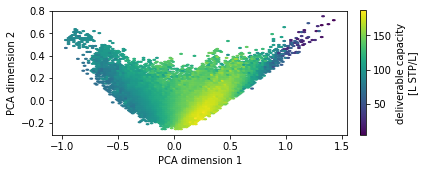

In [5]:
#low dimensional (PCA) visualization of the entire dataset
plt.hexbin(X_2D[:, 0], X_2D[:, 1], C=y)
plt.xlabel('PCA dimension 1')
plt.ylabel('PCA dimension 2')
cb = plt.colorbar(fraction=0.02, pad=0.04)
cb.set_label(label="deliverable capacity\n[L STP/L]")
plt.xticks()
plt.yticks()
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('feature_space_colored_by_DC.pdf')

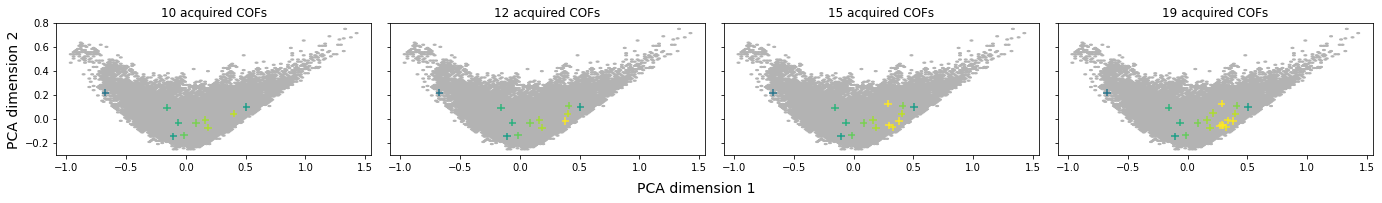

In [38]:
which_BO_run = 0

fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=[3*6.4, 4.8])
nb_acquired = [10, 12, 15, 19]
# gray background
for a in ax:
    a.set_aspect('equal', 'box')
    a.hexbin(X_2D[:, 0], X_2D[:, 1], C=0.3 * np.ones(nb_data), cmap="binary", vmin=0, vmax=1)
    
for i in range(4):
    ids_acquired = bo_res['ids_acquired'][which_BO_run][:nb_acquired[i]]
    assert len(ids_acquired) == nb_acquired[i]
    # use above colorbar to assign color!
    ax[i].scatter(X_2D[ids_acquired, 0], X_2D[ids_acquired, 1], 
                  c=y[ids_acquired], marker="+", s=55, vmin=cb.vmin, vmax=cb.vmax)
    ax[i].set_title('{} acquired COFs'.format(nb_acquired[i]))
    ax[i].tick_params(axis='x', labelsize=10)
ax[0].set_ylabel('PCA dimension 2', fontsize=14)

ax[2].tick_params(axis='y', labelsize=0)


fig.text(0.5, 0.2, 'PCA dimension 1', ha='center', fontsize=14)
plt.tight_layout()
plt.savefig("feature_space_acquired_COFs.pdf")

# search efficiency
first, max $y$ among acquired set.

In [57]:
y_max_mu    = np.zeros(bo_res['nb_iterations'])
y_max_sigma = np.zeros(bo_res['nb_iterations'])
for i in range(1, bo_res['nb_iterations']):
    y_maxes = np.max(y[bo_res['ids_acquired'][:, :i]], axis=1) # among runs
    
    y_max_mu[i]    = np.mean(y_maxes)
    y_max_sigma[i] = np.std(y_maxes)

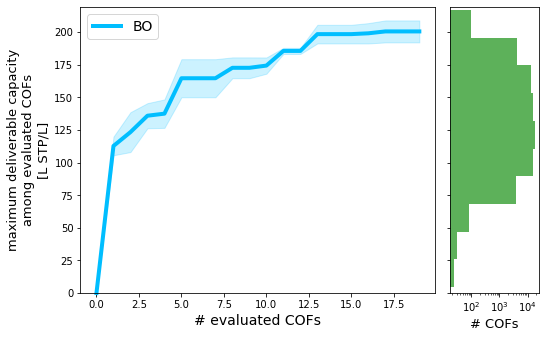

In [61]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]}, figsize=[1.2 * 6.4, 4.8], sharey=True)
axs[0].plot(np.arange(bo_res['nb_iterations']), y_max_mu, label='BO', color=search_to_color['BO'], lw=4, clip_on=False)
axs[0].fill_between(np.arange(bo_res['nb_iterations']), y_max_mu - y_max_sigma, 
                                                        y_max_mu + y_max_sigma, 
                    alpha=0.2, ec="None", color=search_to_color['BO'])

axs[0].set_xlabel('# evaluated COFs', fontsize=14)
axs[0].set_ylabel('maximum deliverable capacity\namong evaluated COFs\n[L STP/L]', fontsize=13)
axs[0].legend(fontsize=14)


# axs[0].set_xlim([0, ])
axs[0].set_ylim(ymin=0.0)

axs[1].hist(y, orientation="horizontal", color=cool_colors[7])
axs[1].set_xlabel("# COFs", fontsize=13)
axs[1].set_xscale("log")
plt.tight_layout()
plt.savefig("search_efficiency_max_found.pdf")